In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
model_dict = {f'{i}en{j}de': f'{i}-Encoder' for i in range(2, 8, 2) for j in range(1, 2)}
model_dict['wav2vec'] = 'wav2vec2-base'
model_dict['imagenet'] = 'ImageNet'

In [5]:
model_dir = 'model/mae-ast_imbalance/20 epochs - with seed, scheduler'
model_list = os.listdir(model_dir)
scratch_dict = {i: 'pretrain' if 'scratch' not in i else 'scratch' if (('lr' not in i) and ('scratch' in i)) else 'scratch+' for i in model_list}
#print(model_list)
test_dict = {}
data_df = pd.DataFrame()
for idx, model in enumerate(model_list):
    log_path = os.path.join(model_dir, model_list[idx])
    log_dir = os.listdir(log_path)
    #print(model)
    test_log = [file for file in log_dir if file.endswith('.txt')]
    assert len(test_log)==1
    test_file = os.path.join(log_path, test_log[0])
    graphs_file = pd.read_csv(os.path.join(log_path, 'lightning_log/metrics.csv'))

    for j in ['train', 'val', 'test']:

        if j == 'train':
            df = graphs_file[[col for col in graphs_file.columns if (('train' in col) and ('epoch' in col))]].dropna().reset_index(drop=True)
            df.rename(columns={name: name.removesuffix('_epoch') for name in df.columns}, inplace=True)
        else:
            df = graphs_file[[col for col in graphs_file.columns if j in col]].dropna().reset_index(drop=True)

        col_name = f'{model[:6]}'
        col_name = f'{col_name} {scratch_dict[model]}'
        df.rename(columns={name: f'{name} - {col_name}' for name in df.columns}, inplace=True)
        data_df = pd.concat((data_df, df), axis=1)

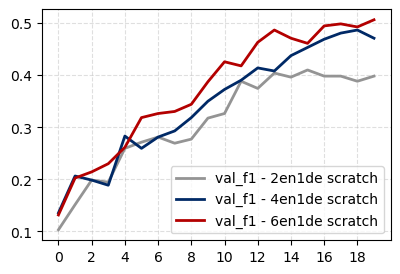

In [25]:
from collections import OrderedDict

def plot_cross_comp(data_type='val', metric='f1', model='scratch', neg='scratch+', linewidth=2, save_plot=False):
    color_map = {
        '2en1de': '#949494',
        '4en1de': '#002966',
        '6en1de': '#b30000'
    }
    plt.figure(figsize=[4.5,3])
    for i in data_df:
        if not neg in i and model in i and metric in i and data_type in i and '2en1de' in i:
            plt.plot(data_df[i], label=i, lw=linewidth, color=color_map['2en1de'])
        if not neg in i and model in i and metric in i and data_type in i and '4en1de' in i:
            plt.plot(data_df[i], label=i, lw=linewidth, color=color_map['4en1de'])
        if not neg in i and model in i and metric in i and data_type in i and '6en1de' in i:
            plt.plot(data_df[i], label=i, lw=linewidth, color=color_map['6en1de'])
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_entries = OrderedDict(zip(labels, handles))
    plt.legend(unique_entries.values(), unique_entries.keys(), loc='lower right')
    plt.xlim(-1, 20)
    plt.xticks(np.arange(0, 20, 2))
    plt.grid(True, linestyle='--', alpha=0.4)
    if save_plot:
        plt.savefig(os.path.join(model_dir, f'{model}-{metric}.pdf'), bbox_inches='tight', pad_inches=0)
    plt.show()
plot_cross_comp(model='scratch', neg='scratch+', save_plot=False)

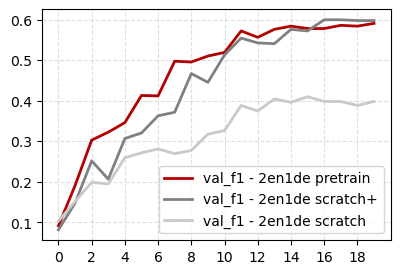

In [18]:
def plot_model_comp(data_type='val', metric='f1', model='2en1de', linewidth=2, save_plot=False):

    color_map = {
        'pretrain': '#b30000',
        'scratch': '#c9c9c9',
        'scratch+': '#808080'
    }
    plt.figure(figsize=[4.5,3])
    for i in data_df:
        if model in i and metric in i and data_type in i:
            color = 'pretrain' if 'pretrain' in i else 'scratch+' if 'scratch+' in i else 'scratch'
            plt.plot(data_df[i], label=i, lw=linewidth, color=color_map[color])
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_entries = OrderedDict(zip(labels, handles))
    plt.legend(unique_entries.values(), unique_entries.keys(), loc='lower right')
    plt.xlim(-1, 20)
    plt.xticks(np.arange(0, 20, 2))
    plt.grid(True, linestyle='--', alpha=0.4)
    if save_plot:
        plt.savefig(os.path.join(model_dir, f'{model}-{metric}.pdf'), bbox_inches='tight', pad_inches=0)
    plt.show()
plot_model_comp(model='2en1de', save_plot=False)